In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns
sns.set_theme()

In [2]:
base_dir = '/Users/das/work/svn/Gits/a_Projects/101_clembench/clembench-runs'

## Load

Load and massage into the right form the model characteristics file:

In [3]:
modprop_df = pd.read_csv(base_dir + '/Addenda/ModelAnalysis2024/Results/model_characteristics.csv')
modprop_df['Release Date'] = pd.to_datetime(modprop_df['Release Date'])
modprop_df['Cut-off Date'] = pd.to_datetime(modprop_df['Cut-off Date'])

## well fuck me. Turns out that the model names can contain trailing whitespaces...
modprop_df['Model Name'] = modprop_df['Model Name'].str.strip()

In [4]:
modprop_df.head()

,Model Provider,Model Name,Training Data Size (in trillions),Cut-off Date,Parameter Size (in billions),Release Date,Context Length (in thousands),Commercial,Multilingual,Multimodal,Base Model,Instruction Tuning Data
0,01-ai,yi-34b-chat,3.0,NaT,34.0,2023-11-01,4,0,1,0,NaN,NaN
1,01-ai,yi-1.5-6b-chat,3.6,NaT,6.0,2024-05-01,32,0,1,0,NaN,NaN
2,01-ai,yi-1.5-9b-chat,3.6,NaT,9.0,2024-05-01,4,0,1,0,NaN,NaN
3,01-ai,yi-1.5-34b-chat,3.6,NaT,34.0,2024-05-01,32,0,1,0,NaN,NaN
4,Allenai,tulu-2-dpo-70b,NaN,NaT,70.0,2024-11-01,2,0,0,0,llama-2-70b-hf,"Ultrafeedback-binarized, tulu-v2-sft-mixture"


Load results file, bring the model names into the standard format, and merge the two files

In [5]:
v16 = pd.read_csv(base_dir + '/v1.6/results.csv')
#v16.loc[:,'model'] = v16.iloc[:,0].str.replace(r'(\w*)-(?:hf-)?t0.0.*', r'\1').str.lower()
v16.loc[:,'model'] = v16.iloc[:,0].str.replace(r'(\w*)-t0.0.*', r'\1').str.lower()


## f me part II: turns out that the results.csv has openchat_3.5, and modprop has openchat-3.5
##  normalise to the latter
v16.loc[v16.model == 'openchat_3.5', 'model'] = 'openchat-3.5'

/var/folders/v4/sxby0fb08xjbdx001s6j3wrh0000gq/T/ipykernel_62242/3022694443.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  v16.loc[:,'model'] = v16.iloc[:,0].str.replace(r'(\w*)-t0.0.*', r'\1').str.lower()


In [6]:
merged = pd.merge(left=modprop_df, right=v16, left_on='Model Name', right_on='model')

In [7]:
set(v16.model) - set(merged.model)

{'sheep-duck-llama-2-13b',
 'sus-chat-34b',
 'vicuna-13b-v1.5',
 'vicuna-33b-v1.3',
 'wizardlm-13b-v1.2'}

## Analyse

Investigate: Is there a predictable relationship between # parameters and clemscore?

In [8]:
merged.columns

Index(['Model Provider', 'Model Name', 'Training Data Size (in trillions)',
       'Cut-off Date', 'Parameter Size (in billions)', 'Release Date',
       'Context Length (in thousands)', 'Commercial', 'Multilingual',
       'Multimodal', 'Base Model ', 'Instruction Tuning Data', 'Unnamed: 0',
       '-, clemscore', 'all, Average % Played', 'all, Average Quality Score',
       'imagegame, % Played', 'imagegame, Quality Score',
       'imagegame, Quality Score (std)', 'privateshared, % Played',
       'privateshared, Quality Score', 'privateshared, Quality Score (std)',
       'referencegame, % Played', 'referencegame, Quality Score',
       'referencegame, Quality Score (std)', 'taboo, % Played',
       'taboo, Quality Score', 'taboo, Quality Score (std)',
       'wordle, % Played', 'wordle, Quality Score',
       'wordle, Quality Score (std)', 'wordle_withclue, % Played',
       'wordle_withclue, Quality Score',
       'wordle_withclue, Quality Score (std)', 'wordle_withcritic, % Playe

In [9]:
psize = 'Parameter Size (in billions)'
cscor = '-, clemscore'
tsize = 'Training Data Size (in trillions)'

pslog = 'log10(Parameter Size (in billions)'

# actually add a column, so that the plots automatically get the right label
merged.loc[:, pslog] = np.log10(merged[psize])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


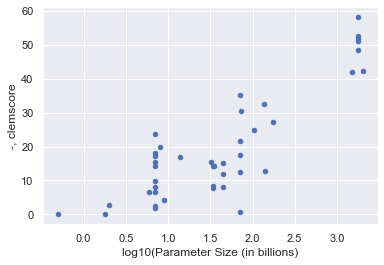

In [10]:
merged.dropna(subset=[psize]).plot(kind='scatter',
                                   x=pslog,
                                   y=cscor) #, logx=True)
plt.savefig('Out/size-vs-score.png', bbox_inches='tight')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Parameter Size (in billions)', ylabel='-, clemscore'>

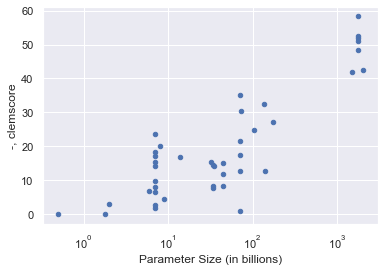

In [11]:
merged.dropna(subset=[psize]).plot(kind='scatter',
                                   x=psize,
                                   y=cscor, logx=True)

In [12]:
xs = merged.dropna(subset=[psize])[psize]
xl = merged.dropna(subset=[psize])[pslog]
ys = merged.dropna(subset=[psize])[cscor]

In [13]:
len(xs), len(ys)

(42, 42)

<AxesSubplot:xlabel='Parameter Size (in billions)', ylabel='-, clemscore'>

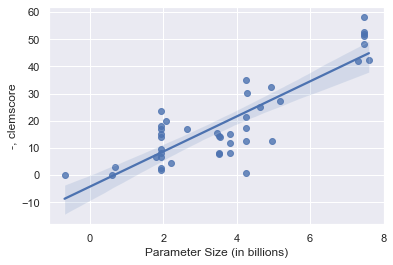

In [14]:
sns.regplot(x=np.log(xs), y=ys)

<AxesSubplot:xlabel='log10(Parameter Size (in billions)', ylabel='-, clemscore'>

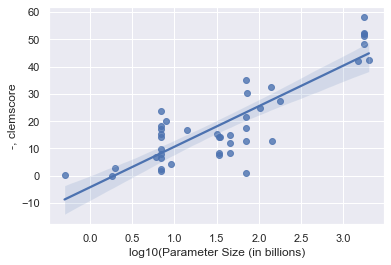

In [15]:
sns.regplot(x=xl, y=ys)

<AxesSubplot:xlabel='Parameter Size (in billions)', ylabel='-, clemscore'>

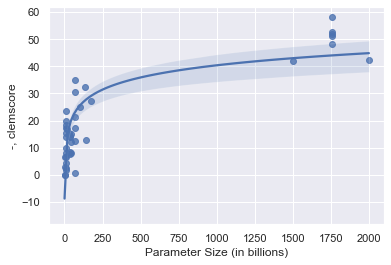

In [16]:
sns.regplot(x=xs, y=ys, logx=True)

Fit a linear-log model: Score ~ log(Parameters)
( https://kenbenoit.net/assets/courses/ME104/logmodels2.pdf )

In [17]:
data = merged.dropna(subset=[psize, tsize])[[psize, pslog, tsize, cscor]].copy(deep=True)
data.columns = ['Parameters', 'log10(Parameters)', 'Data', 'Score']

In [18]:
results = smf.ols('Score ~ np.log(Parameters)', data=data).fit()

In [19]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     23.56
Date:                Mon, 10 Jun 2024   Prob (F-statistic):           0.000127
Time:                        23:43:18   Log-Likelihood:                -69.529
No. Observations:                  20   AIC:                             143.1
Df Residuals:                      18   BIC:                             145.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.8909      3

A significant regression equation was found (F(1, 18) = 23.56, p < 0.000), with an R^2 of .567).

.... and adding in the size of training data.. explains a bit more:

In [20]:
results = smf.ols('Score ~ np.log(Parameters) + np.log(Data)', data=data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     17.31
Date:                Mon, 10 Jun 2024   Prob (F-statistic):           7.95e-05
Time:                        23:43:18   Log-Likelihood:                -66.792
No. Observations:                  20   AIC:                             139.6
Df Residuals:                      17   BIC:                             142.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -5.8290      3

f(2,17) = 17.31, p < 0.000, R^2 = .67